In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import datasets, layers, models, losses
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D
from keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import glob

from keras import utils
utils.set_random_seed(3)

2024-06-02 18:16:14.686583: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-02 18:16:14.733751: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-02 18:16:14.736012: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-02 18:16:15.580935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
NUM_EPOCHS = 200
LATENT_DIMENSIONS = 5

In [4]:
df_train_untrack = pd.read_csv('/uscms/home/jieun201/nobackup/YOURWORKINGAREA/jun2/274TrainSetUntracked.csv')
df_test_untrack = pd.read_csv('/uscms/home/jieun201/nobackup/YOURWORKINGAREA/jun2/274TestSetUntracked.csv')

In [5]:
x_train_U = df_train_untrack.values
x_test_U = df_test_untrack.values

n_train_U = df_train_untrack.shape[0] 
n_test_U = df_test_untrack.shape[0]

print (x_train_U.shape)
print (x_test_U.shape)

(200000, 274)
(500000, 274)


In [6]:
scaler = StandardScaler()
x_train_U = scaler.fit_transform(x_train_U.reshape(-1, x_train_U.shape[-1])).reshape(x_train_U.shape)
x_test_U = scaler.transform(x_test_U.reshape(-1, x_test_U.shape[-1])).reshape(x_test_U.shape)

In [7]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test_U.shape[1:]
latent_dim = LATENT_DIMENSIONS
autoencoder = Autoencoder(latent_dim, shape)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

history = autoencoder.fit(x_train_U, x_train_U,
                epochs=NUM_EPOCHS,
                shuffle=True,
                batch_size=1024,
                callbacks=[es],
                validation_data=(x_test_U, x_test_U),verbose=1)



2024-06-02 18:16:31.088485: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-02 18:16:31.091980: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/200
196/196 [==============================] - 3s 14ms/step - loss: 1.1173 - val_loss: 1.0687
Epoch 2/200
196/196 [==============================] - 1s 7ms/step - loss: 0.9951 - val_loss: 1.0373
Epoch 3/200
196/196 [==============================] - 1s 7ms/step - loss: 0.9739 - val_loss: 1.0225
Epoch 4/200
196/196 [==============================] - 1s 7ms/step - loss: 0.9623 - val_loss: 1.0134
Epoch 5/200
196/196 [==============================] - 1s 7ms/step - loss: 0.9546 - val_loss: 1.0065
Epoch 6/200
196/196 [==============================] - 1s 7ms/step - loss: 0.9481 - val_loss: 1.0005
Epoch 7/200
196/196 [==============================] - 1s 7ms/step - loss: 0.9428 - val_loss: 0.9957
Epoch 8/200
196/196 [==============================] - 1s 7ms/step - loss: 0.9384 - val_loss: 0.9919
Epoch 9/200
196/196 [==============================] - 1s 7ms/step - loss: 0.9349 - val_loss: 0.9887
Epoch 10/200
196/196 [==============================] - 1s 7ms/step - loss: 0.9319 - val_l

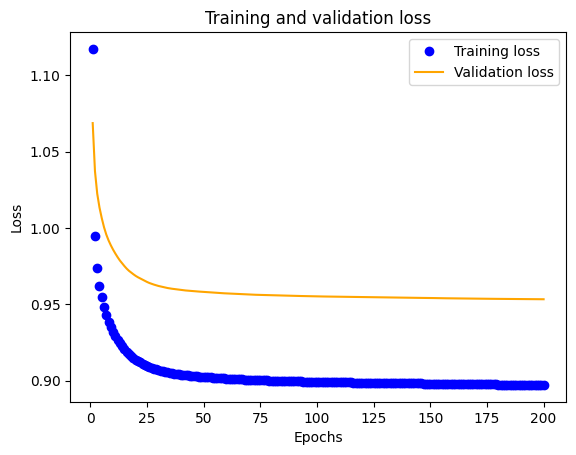

In [8]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('loss.png')

In [9]:
Train = pd.read_csv('/uscms/home/jieun201/nobackup/YOURWORKINGAREA/jun2/trackedTestSetForAuto.ipynb') #this is .csv fix name

df_2_train = Train[0:100000]
df_2_test = Train[100000:600000]

x_train = df_2_train.values
x_test = df_2_test.values

n_train = df_2_train.shape[0] 
n_test =df_2_test.shape[0]

print (x_train.shape)
print (x_test.shape)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

(100000, 274)
(500000, 274)


In [11]:
encoded_imgs_Tracked = autoencoder.encoder(x_test).numpy() #use autoencoder to encode tracked test set

In [12]:
len(encoded_imgs_Tracked)

500000

In [13]:
encoded_imgs_UnTracked = autoencoder.encoder(x_test_U).numpy()   #use autoencoder to encode untrakced test set

In [15]:
#fit on UNTRACKED then transform on untracked, also pass in labels
import umap
reducer= umap.UMAP(random_state=99)

/home/jieun201/.local/lib/python3.9/site-packages/numba/core/cpu.py:99: UserWarning: Numba extension module 'awkward.numba' failed to load due to 'AttributeError(partially initialized module 'awkward' has no attribute '_nplikes' (most likely due to a circular import))'.
  numba.core.entrypoints.init_all()
/home/jieun201/.local/lib/python3.9/site-packages/numba/core/cpu.py:99: UserWarning: Numba extension module 'vector' failed to load due to 'AttributeError(partially initialized module 'awkward' has no attribute '_nplikes' (most likely due to a circular import))'.
  numba.core.entrypoints.init_all()
/home/jieun201/.local/lib/python3.9/site-packages/numba/core/cpu.py:99: UserWarning: Numba extension module 'awkward._connect._numba' failed to load due to 'AttributeError(partially initialized module 'awkward' has no attribute '_nplikes' (most likely due to a circular import))'.
  numba.core.entrypoints.init_all()


In [16]:
u = reducer.fit_transform(encoded_imgs_UnTracked) #first, fit untracked

/home/jieun201/.local/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [17]:
u

array([[12.921468  , -0.93705463],
       [ 1.9126643 ,  8.173426  ],
       [ 0.57298803, 10.722281  ],
       ...,
       [ 2.6630228 ,  0.96728796],
       [-5.4136653 ,  8.943275  ],
       [-3.1417363 ,  6.5653896 ]], dtype=float32)

In [18]:
len(u)

500000

In [19]:
df_labeled_untracked = pd.DataFrame(u, columns=['y', 'x'])   #untracked clusters

In [20]:
df_labeled_untracked.to_csv('testOutputNumpyArray.csv', index=False)   #untracked clusters

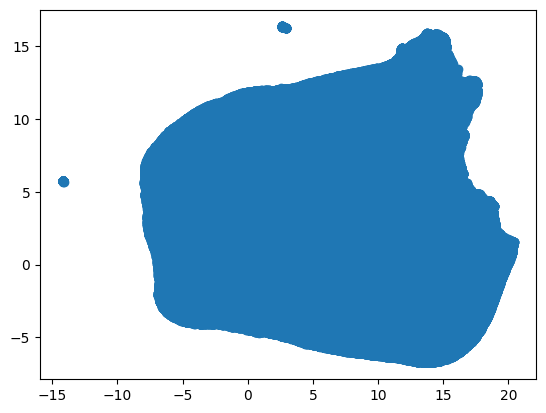

In [21]:
plt.scatter(df_labeled_untracked['y'],df_labeled_untracked['x'])  #untracked

In [24]:
embeddingTracked=reducer.transform(encoded_imgs_Tracked) #TRACKED CLUSTERS

/home/jieun201/.local/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [25]:
df_labeled_tracked_2 = pd.DataFrame(embeddingTracked, columns=['y', 'x'])
df_labeled_tracked_2
df_labeled_tracked_2.to_csv('trainingSetTrackedOutputNumpyArray.csv', index=False)

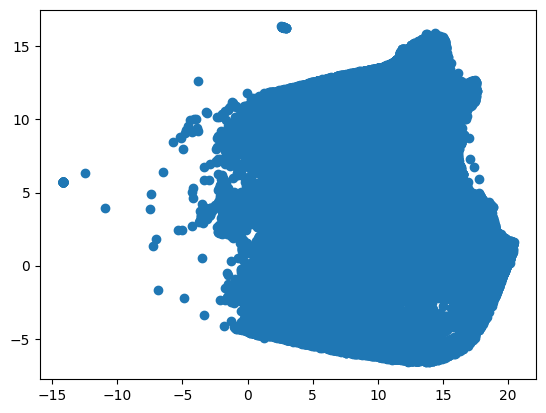

In [26]:
plt.scatter(df_labeled_tracked_2['y'],df_labeled_tracked_2['x'])  #tracked

/tmp/ipykernel_701197/417173366.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*u.T, s=0.1, cmap='Spectral', alpha=1.0)
/tmp/ipykernel_701197/417173366.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*embeddingTracked.T, s=0.1,  cmap='Spectral', alpha=1.0)


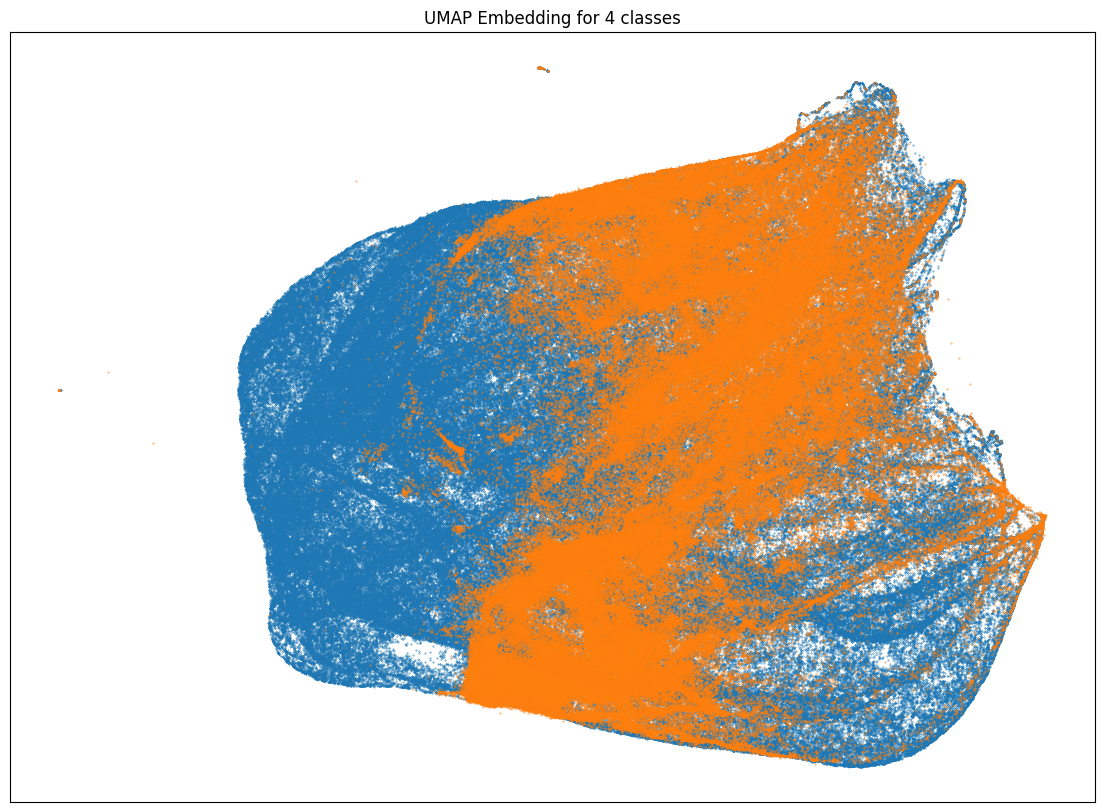

In [27]:
#classes = ['0', '1', '2']
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*u.T, s=0.1, cmap='Spectral', alpha=1.0)

plt.scatter(*embeddingTracked.T, s=0.1,  cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
#cbar = plt.colorbar(boundaries=np.arange(4)-0.5)
#cbar.set_ticks(np.arange(3))
#cbar.set_ticklabels(classes)
plt.title('UMAP Embedding for 4 classes');  # IGNORE TITLE!!!!!!!!!!!!!!!!!!!!!!!!! delete, was leftover